## Approach
**[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)** is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. The dataset serves as a direct drop-in replacement for the original [MNIST dataset](http://yann.lecun.com/exdb/mnist/) for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

In this work, I will train a Convolutional Neural Network classifier with 4 convolution layer using the Keras deep learning library. I also use **batch normalization** to preprocess every layer of the network. The model is first trained for 10 epochs with batch size of 256, compiled with `categorical_crossentropy` loss function and `Adam` optimizer. Then, I added **data augmentation**, which generates new training samples by rotating, shifting and zooming on the training samples, and trained for another 50 epochs.

I will first split the original training data (60,000 images) into 80% training (48,000 images) and 20% validation (12000 images) optimize the classifier, while keeping the test data (10,000 images) to finally evaluate the accuracy of the model on the data it has never seen. This helps to see whether I'm over-fitting on the training data and whether I should lower the learning rate and train for more epochs if validation accuracy is higher than training accuracy or stop over-training if training accuracy shift higher than the validation.

In [1]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load training and test data into dataframes
data_train = pd.read_csv('data/fashion-mnist_train.csv')
data_test = pd.read_csv('data/fashion-mnist_test.csv')

# X forms the training images, and y forms the training labels
X = np.array(data_train.iloc[:, 1:])
y = to_categorical(np.array(data_train.iloc[:, 0]))

# Here I split original training data to sub-training (80%) and validation data (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

# X_test forms the test images, and y_test forms the test labels
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Processing Data
After loading and splitting the data, I preprocess them by reshaping them into the shape the network expects and scaling them so that all values are in the [0, 1] interval. Previously, for instance, the training data were stored in an array of shape (60000, 28, 28) of type uint8 with values in the [0, 255] interval. I transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1.

In [2]:
# Each image's dimension is 28 x 28
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

# Prepare the training images
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_train /= 255

# Prepare the test images
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_test = X_test.astype('float32')
X_test /= 255

# Prepare the validation images
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_val = X_val.astype('float32')
X_val /= 255

## CNN with 4 Convolutional Layers
This CNN takes as input tensors of shape *(image_height, image_width, image_channels)*. In this case, I configure the CNN to process inputs of size *(28, 28, 1)*, which is the format of the FashionMNIST images. I do this by passing the argument *input_shape=(28, 28, 1)* to the first layer.

* The *Conv2D* layers are used for the **convolution** operation that extracts features from the input images by sliding a convolution filter over the input to produce a feature map. Here I choose feature map with size 3 x 3. 
* The *MaxPooling2D* layers are used for the **max-pooling** operation that reduces the dimensionality of each feature, which helps shorten training time and reduce number of parameters. Here I choose the pooling window with size 2 x 2.
* To normalize the input layers, I use the *BatchNormalization* layers to adjust and scale the activations. **Batch Normalization** reduces the amount by what the hidden unit values shift around (covariance shift). Also, it allows each layer of a network to learn by itself a little bit more independently of other layers.
* To combat overfititng, I use the *Dropout* layers, a powerful regularization technique. **Dropout** is the method used to reduce overfitting. It forces the model to learn multiple independent representations of the same data by randomly disabling neurons in the learning phase. For example, the 1st dropout layer will randomnly disable 25% of the outputs.
* In total, this model has 4 *Conv2D* layers, 2 *MaxPooling* layers, 6 *BatchNormalization* layers, and 5 *Dropout* layers.
* The next step is to feed the last output tensor into a stack of *Dense* layers, otherwise known as **fully-connected** layers. These densely connected classifiers process vectors, which are 1D, whereas the current output is a 3D tensor. Thus, I need to **flatten** the 3D outputs to 1D, and then add 2 *Dense* layers on top.
* I do a 10-way classification (as there are 10 classes of fashion images), using a final layer with 10 outputs and a softmax activation. **Softmax** activation enables me to calculate the output based on the probabilities. Each class is assigned a probability and the class with the maximum probability is the model’s output for the input.

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

cnn4 = Sequential()
cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn4.add(BatchNormalization())

cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.25))

cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

cnn4.add(Flatten())

cnn4.add(Dense(512, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))

cnn4.add(Dense(128, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))

cnn4.add(Dense(10, activation='softmax'))

When compiling the model, I choose **categorical_crossentropy** as the loss function (which is relevent for multiclass, single-label classification problem) and **Adam** optimizer.
* The cross-entropy loss calculates the error rate between the predicted value and the original value. The formula for calculating cross-entropy loss is given [here](https://en.wikipedia.org/wiki/Cross_entropy). Categorical is used because there are 10 classes to predict from. If there were 2 classes, I would have used binary_crossentropy.
* The Adam optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is responsible for updating the weights of the neurons via backpropagation. It calculates the derivative of the loss function with respect to each weight and subtracts it from the weight. That is how a neural network learns.

In [4]:
cnn4.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Let’s look at how the dimensions of the feature maps change with every successive layer:

In [5]:
cnn4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
__________

* 1,219,754 parameters are available to be trained.
* The output of the *Conv2D* and *MaxPooling2D* layers are 3D tensors of shape *(height, width, channels)*.
* The number of channels is controlled by the 1st argument passed to the *Conv2D* layer (32).
* The (4, 4, 128) outputs from the 3rd *Dropout* layer are flattened into vectors of shape (2048,) before going through 3 *Dense* layers.

## Training the Model
As previously mentioned, I train the model with batch size of 256 and 10 epochs on both training and validation data.

In [7]:
history4 = cnn4.fit(X_train, y_train,
          batch_size=256,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 366s 8ms/step - loss: 0.6095 - acc: 0.7794 - val_loss: 0.3938 - val_acc: 0.8507
Epoch 2/10
48000/48000 [==============================] - 377s 8ms/step - loss: 0.4175 - acc: 0.8507 - val_loss: 0.3296 - val_acc: 0.8808
Epoch 3/10
48000/48000 [==============================] - 366s 8ms/step - loss: 0.3469 - acc: 0.8760 - val_loss: 0.2820 - val_acc: 0.8965
Epoch 4/10
48000/48000 [==============================] - 379s 8ms/step - loss: 0.3147 - acc: 0.8874 - val_loss: 0.2732 - val_acc: 0.9020
Epoch 5/10
48000/48000 [==============================] - 384s 8ms/step - loss: 0.2941 - acc: 0.8946 - val_loss: 0.2740 - val_acc: 0.8986
Epoch 6/10
48000/48000 [==============================] - 381s 8ms/step - loss: 0.2698 - acc: 0.9042 - val_loss: 0.2487 - val_acc: 0.9098
Epoch 7/10
48000/48000 [==============================] - 378s 8ms/step - loss: 0.2613 - acc: 0.9067 - val_loss: 0.2694 - 

In [8]:
score4 = cnn4.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score4[0])
print('Test accuracy:', score4[1])

Test loss: 0.26567093777656553
Test accuracy: 0.9052


My accuracy is 90.52%, pretty powerful!

## Data Augmentation
Overfitting can be caused by having too few samples to learn from, making me unable to train a model that can generalize to new data. Given infinite data, my model would be exposed to every possible aspect of the data distribution at hand: I would never overfit. 

**Data augmentation** takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, my model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ImageDataGenerator instance.
* *rotation_range* is a value in degrees (0–180), a range within which to randomly rotate pictures.
* *width_shift* and *height_shift* are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* *shear_range* is for randomly applying shearing transformations.
* *zoom_range* is for randomly zooming inside pictures.

In [9]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, y_train, batch_size=256)
val_batches = gen.flow(X_val, y_val, batch_size=256)

Let's train the network using data augmentation.

In [10]:
history4 = cnn4.fit_generator(batches, steps_per_epoch=48000//256, epochs=50,
                    validation_data=val_batches, validation_steps=12000//256, use_multiprocessing=True)

Epoch 1/50
187/187 [==============================] - 326s 2s/step - loss: 0.4025 - acc: 0.8551 - val_loss: 0.3416 - val_acc: 0.8738
Epoch 2/50
187/187 [==============================] - 318s 2s/step - loss: 0.3599 - acc: 0.8684 - val_loss: 0.3174 - val_acc: 0.8852
Epoch 3/50
187/187 [==============================] - 319s 2s/step - loss: 0.3363 - acc: 0.8777 - val_loss: 0.3179 - val_acc: 0.8828
Epoch 4/50
187/187 [==============================] - 312s 2s/step - loss: 0.3286 - acc: 0.8819 - val_loss: 0.2877 - val_acc: 0.8959
Epoch 5/50
187/187 [==============================] - 318s 2s/step - loss: 0.3190 - acc: 0.8841 - val_loss: 0.3098 - val_acc: 0.8868
Epoch 6/50
187/187 [==============================] - 314s 2s/step - loss: 0.3109 - acc: 0.8870 - val_loss: 0.3295 - val_acc: 0.8761
Epoch 7/50
187/187 [==============================] - 316s 2s/step - loss: 0.3026 - acc: 0.8900 - val_loss: 0.2833 - val_acc: 0.8954
Epoch 8/50
187/187 [==============================] - 315s 2s/step - 

In [11]:
score4 = cnn4.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score4[0])
print('Test accuracy:', score4[1])

Test loss: 0.1776888778269291
Test accuracy: 0.9352


Okay, I improved the accuracy to 93.52%!

## Results
Let's plot training and validation accuracy as well as training and validation loss.

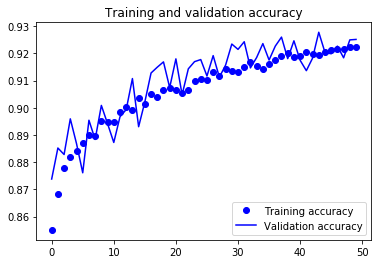

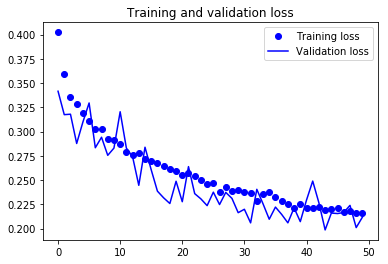

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = history4.history['acc']
val_accuracy = history4.history['val_acc']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

These plots look decent: The training curves are closely tracking the validation curves.

## Classification Report
I can summarize the performance of my classifier as follows:

In [14]:
# get the predictions for the test data
predicted_classes = cnn4.predict_classes(X_test)

# get the indices to be plotted
y_true = data_test.iloc[:, 0]
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [15]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.91      0.87      0.89      1000
    Class 1       0.99      1.00      1.00      1000
    Class 2       0.95      0.85      0.90      1000
    Class 3       0.94      0.96      0.95      1000
    Class 4       0.86      0.94      0.90      1000
    Class 5       0.99      0.98      0.99      1000
    Class 6       0.78      0.81      0.80      1000
    Class 7       0.95      0.98      0.97      1000
    Class 8       0.99      0.99      0.99      1000
    Class 9       0.99      0.97      0.98      1000

avg / total       0.94      0.94      0.94     10000



It's apparent that the classifier is underperforming for class 6 in terms of both precision and recall. For class 4, the classifier is slightly lacking precision; whereas for class 0 and 2, it is slightly lacking recall.

Perhaps I would gain more insight after visualizing the correct and incorrect predictions.

Here is a subset of correctly predicted classes.

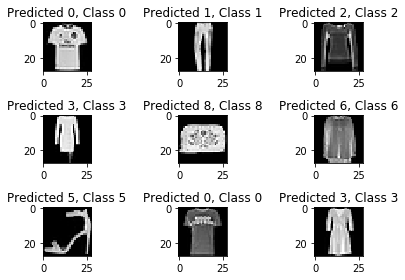

In [16]:
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_true[correct]))
    plt.tight_layout()

And here is a subset of incorrectly predicted classes:

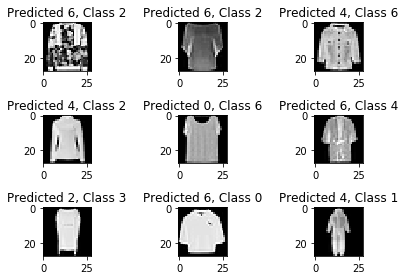

In [17]:
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_true[incorrect]))
    plt.tight_layout()

## Visualizing What My Model Learns
It’s often said that deep-learning models are “black boxes”: learning representations that are difficult to extract and present in a human-readable form. Although this is partially true for certain types of deep-learning models, it’s definitely not true for convnets. The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts.

Here I attempt to visualize the intermediate CNN outputs (intermediate activations). Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its *activation*, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network. 

I want to visualize feature maps with three dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.

I first get an input test image (#2018).

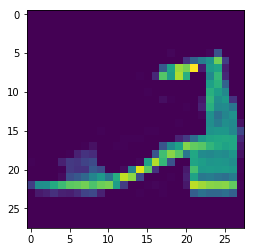

In [18]:
test_im = X_train[2018]
plt.imshow(test_im.reshape(28,28), cmap='viridis', interpolation='none')
plt.show()

In order to extract the feature maps I want to look at, I create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers. To do this, I use the Keras class Model. A model is instantiated using two arguments: an input tensor (or list of input tensors) and an output tensor (or list of output tensors). The resulting class is a Keras model, mapping the specified inputs to the specified outputs. When fed an image input, this model returns the values of the layer activations in the original model.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=[<tf.Tenso...)`
  


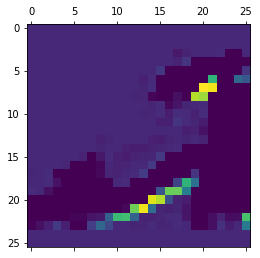

In [20]:
from keras import models
# extracts the outputs of the top 8 layers
layer_outputs = [layer.output for layer in cnn4.layers[:8]]

# creates a model that will return these outputs, given the model input
activation_model = models.Model(input=cnn4.input, output=layer_outputs)

# returns a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(test_im.reshape(1,28,28,1))

# activation of the 1st convolution layer
first_layer_activation = activations[0]

# display the 1st channel of the activation of the 1st layer of the original model
plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')

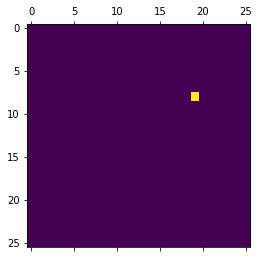

In [21]:
# display the 5th channel of the activation of the 1st layer of the original model
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')

Let's plot a complete visualization of all the activations in the network. I extract and plot every channel in each of the eight activation maps, and then stack the results in one big image tensor, with channels stacked side by side.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


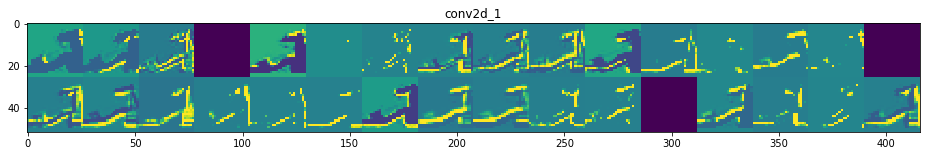

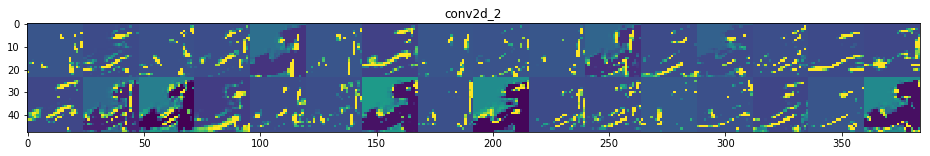

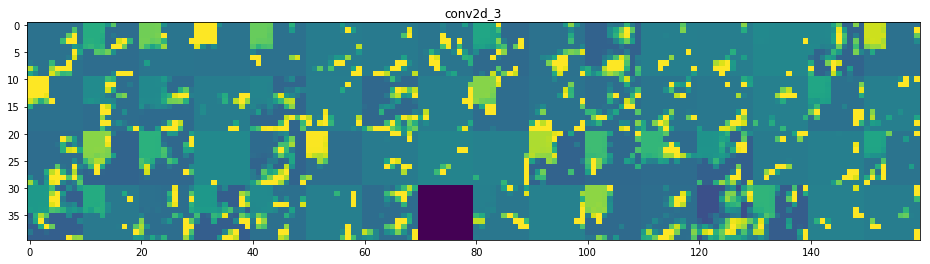

In [22]:
layer_names = []
for layer in cnn4.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')